# Administración del Riesgo de Mercado (Fórex~FX)

por López Lazareno Diego Alberto IF722100

In [1]:
# Librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import yfinance as yf 
import datetime as dt

## -------------------------------------------------- Funciones -------------------------------------------------- ##

# VaR Paramétrico (portafolio de un único activo)
def VaR_Parametric(portfolioValue : "Valor del portafolio", confidenceLevel : "Nivel de confianza", 
                         t : "Días para el cálculo del VaR", data : "Datos históricos del activo"):
    
    data = data[data.index > (data.index[-1] - dt.timedelta(93))].pct_change().dropna()
    sigma = np.std(data, ddof = 1)
    Z = st.distributions.norm.ppf(confidenceLevel / 100)
    VaR = "${:,.2f}".format(portfolioValue * np.sqrt(t) * Z * sigma)
    
    return VaR

# VaR Histórico (portafolio de un único activo)
def VaR_Historic(portfolioValue : "Valor del portafolio", confidenceLevel : "Nivel de confianza", 
                         t : "Días para el cálculo del VaR", data : "Datos históricos del activo",
                         position : "Short or Long"):
    
    data = data.pct_change().dropna()

    if position == "Short":
        VaR = "${:,.2f}".format(portfolioValue * np.sqrt(t) * np.percentile(data, confidenceLevel))
    else:
        VaR = "${:,.2f}".format(portfolioValue * np.sqrt(t) * np.percentile(data, 100 - confidenceLevel))
    
    return VaR

# VaR Montecarlo (portafolio de un único activo)
def VaR_Montecarlo(portfolioValue : "Valor del portafolio", confidenceLevel : "Nivel de confianza", 
                         t : "Días para el cálculo del VaR", data : "Datos históricos del activo",
                         N : "Simulaciones", sigma : "Volatilidad estimada (anual)", position = "Short or Long"):
    So = data[-1]
    sigma = sigma / np.sqrt(252)
    St = So * np.exp((- sigma ** 2 / 2) * t + np.random.randn(N) * sigma * np.sqrt(t))
    
    if position == "Short":
        VaR = "${:,.2f}".format(portfolioValue * abs(np.percentile(St, confidenceLevel) - So))  
    else:
        VaR = "${:,.2f}".format(portfolioValue * abs(np.percentile(St, 100 - confidenceLevel) - So))
        
    return VaR

# VaR y Expected Shortfall
def VaR_ES_Portfolio(portfolioValue : "Valor del portafolio", confidenceLevel : "Nivel de confianza", 
                     data : "Datos históricos del activo"):
    
    VaR = np.percentile(data, 100 - confidenceLevel)
    ES = np.mean(data[data < VaR])
    
    print("El VaR es de: ", round(VaR * 100, 4), "%, es decir, ", "${:,.2f}".format(portfolioValue * VaR))
    print("El ES es de: ", round(ES * 100, 4), "%, es decir, ", "${:,.2f}".format(portfolioValue * ES))


## Ejercicio a) USD/MXN

Suponga que eres el trader a cargo de la mesa de divisas de BanBajío y al cierre de la sesión de hoy finalizaste con una posición corta de $4$ millones de dólares. ¿De cuánto es tu riesgo para mañana?

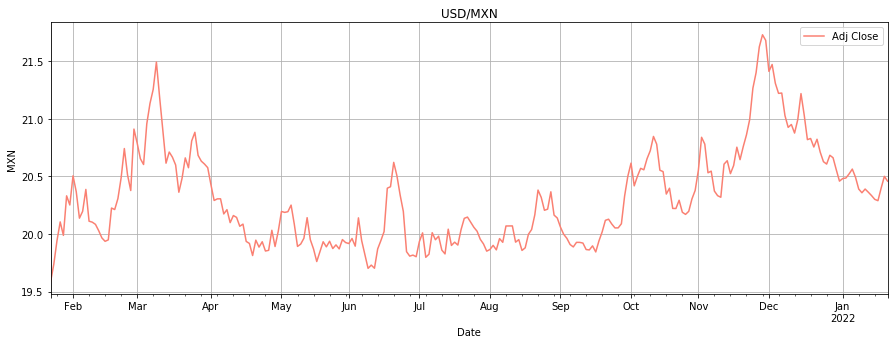

In [2]:
# Descarga de precios de cierre para el par USD/MXN (1 año)
end = dt.datetime.today()
start = end - dt.timedelta(365)
usdmxn = yf.download("MXN=X", progress = False, start = start, end = end)["Adj Close"]

# Visualización
plt.figure(figsize = (15, 5))
plt.title("USD/MXN")
usdmxn.plot(label = "Adj Close", color = "salmon")
plt.ylabel("MXN")
plt.legend(loc = "best")
plt.grid()

### Método Paramétrico

In [3]:
# Se calcula el VaR al 99% con el Método Paramétrico para el día siguiente
portfolioValue = 4000000 * usdmxn.iloc[-1] 
VaR_Parametric(portfolioValue, 99, 1, usdmxn)

'$1,127,537.66'

### Método Histórico

In [4]:
# Se calcula el VaR al 99% con el Método Histórico para el día siguiente
VaR_Historic(portfolioValue, 99, 1, usdmxn, "Short")

'$1,402,592.04'

### Método Montecarlo

In [5]:
# Se calcula el VaR al 99% con el Método Montecarlo para el día siguiente
VaR_Montecarlo(4000000, 99, 1, usdmxn, 10000, 0.0567, "Short")

'$693,894.20'

## Ejercicio b) Portafolio: USD/MXN y EUR/MXN

Suponga que eres el trader a cargo de la mesa de divisas de BanBajío y al cierre de la sesión de hoy finalizaste con:

+ Posición corta de $6$ millones de dólares.
+ Posición larga de $6$ millones de euros.

¿De cuánto es tu riesgo para mañana?

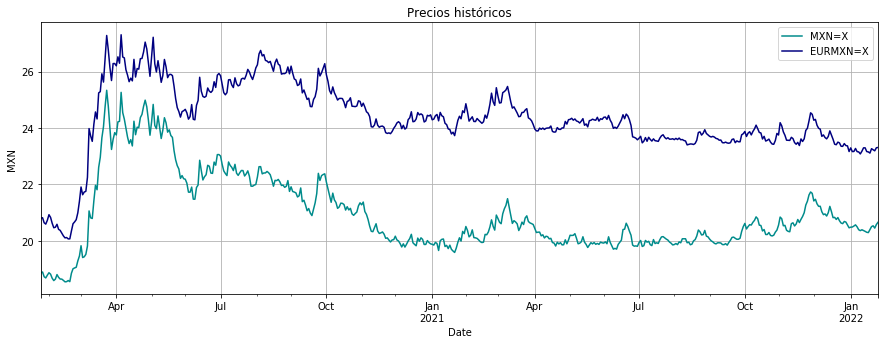

In [2]:
# Descarga de precios (2 años)
end = dt.datetime.today()
start = end - dt.timedelta(2 * 365)
data = pd.DataFrame()
tickers = ["MXN=X", "EURMXN=X"]

for ticker in tickers:
    data[ticker] = yf.download(ticker, start = start, end = end, progress = False)["Adj Close"]

# Visualización
data.plot(figsize = (15, 5), title = "Precios históricos", color = ["darkcyan", "navy"])
plt.ylabel("MXN")
plt.legend(loc = "best")
plt.grid()

In [3]:
# Construcción de portafolio
w1 = 6000000 * data["MXN=X"][-1]
w2 = 6000000 * data["EURMXN=X"][-1]
portfolio = w1 + w2
returns = data.pct_change().dropna()

In [4]:
# Posición corta en USD/MXN y posición larga en EUR/MXN
returns_longShortPortfolio = np.dot(np.array([-w1 / portfolio, w2 / portfolio]), returns.T)
VaR_ES_Portfolio(portfolio, 99, returns_longShortPortfolio)

El VaR es de:  -0.4665 %, es decir,  $-1,230,503.43
El ES es de:  -0.6704 %, es decir,  $-1,768,359.03


In [5]:
# Posición larga en USD/MXN y posición larga en EUR/MXN
returns_longPortfolio = np.dot(np.array([w1 / portfolio, w2 / portfolio]), returns.T)
VaR_ES_Portfolio(portfolio, 99, returns_longPortfolio)

El VaR es de:  -2.0553 %, es decir,  $-5,421,119.22
El ES es de:  -2.5807 %, es decir,  $-6,807,077.71


In [6]:
# Posición corta en USD/MXN y posición corta en EUR/MXN
returns_shortPortfolio = np.dot(np.array([-w1 / portfolio, -w2 / portfolio]), returns.T)
VaR_ES_Portfolio(portfolio, 99, returns_shortPortfolio)

El VaR es de:  -3.1248 %, es decir,  $-8,242,292.24
El ES es de:  -4.1496 %, es decir,  $-10,945,259.65
